<a href="https://colab.research.google.com/github/justincqz/nlp-humor-discriminator/blob/main/data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
# Imports

import re
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, random_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import codecs

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load data

!wget -O train.csv https://drive.google.com/u/0/uc?id=1UgrdjcHHZmAthjusQDAKoSqd37up-41f&export=download
!wget -O dev.csv https://drive.google.com/u/0/uc?id=1rY6A0cN_cxAMK3aMHlTFWxhbcLFomvQL&export=download

train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./dev.csv')

--2021-02-21 13:11:48--  https://drive.google.com/u/0/uc?id=1UgrdjcHHZmAthjusQDAKoSqd37up-41f
Resolving drive.google.com (drive.google.com)... 74.125.142.100, 74.125.142.102, 74.125.142.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-cc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4rnolf2aab31rtobuf27lt5ojhq6mcas/1613913075000/13802342090854404605/*/1UgrdjcHHZmAthjusQDAKoSqd37up-41f [following]
--2021-02-21 13:11:48--  https://doc-00-cc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4rnolf2aab31rtobuf27lt5ojhq6mcas/1613913075000/13802342090854404605/*/1UgrdjcHHZmAthjusQDAKoSqd37up-41f
Resolving doc-00-cc-docs.googleusercontent.com (doc-00-cc-docs.googleusercontent.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to doc-00-cc-docs.googleusercontent.com (doc-00-cc-docs.googleusercontent.com)|74.

In [47]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./dev.csv')

In [48]:
train_df

,id,original,edit,grades,meanGrade
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0
...,...,...,...,...,...
9647,10899,State officials blast ' unprecedented ' DHS <m...,idea,0,0.0
9648,1781,Protesters Rally for <Refugees/> Detained at J...,stewardesses,20000,0.4
9649,5628,Cruise line Carnival Corp. joins the fight aga...,raisin,21000,0.6
9650,14483,Columbia police hunt woman seen with <gun/> ne...,cake,32200,1.4


In [49]:
test_df

,id,original,edit
0,1723,Thousands of gay and bisexual <men/> convicted...,swans
1,12736,Special <prosecutor/> appointed to Trump Russia,chef
2,12274,Spanish police detain man and search Ripoll ad...,squad
3,8823,N.Y. Times <reprimands/> reporter for sharing ...,applauds
4,5087,Vladimir Putin Releases Video Simulation Of Ru...,balloon
...,...,...,...
2414,1202,Supreme <Court/> Once Again Strikes Down Racia...,leaders
2415,14764,Trump Mocks Schumer ’s Tears ; Vows to ‘ Make ...,Insane
2416,12595,US government memo on the <danger/> of leaking...,amusement
2417,70,Newt Gingrich : Join Me in Supporting Judge Ro...,Molest


In [50]:
# Edit sentence with replacement word.
def replace_word(orig, edit):
  return re.sub(r"\<.*\/\>", edit, orig)

# Get word to be replaced.
def get_replaced(orig):
  return re.search(r"\<.*\/\>", orig).group(0)[1:-2]

orig = train_df.iloc[0]['original']
edit = train_df.iloc[0]['edit']
grade = train_df.iloc[0]['meanGrade']
print("Orignal: {}".format(orig))
print("Replacement word: {}".format(edit))

word = get_replaced(orig)
print("Matched word: {}".format(word))

replaced_text = replace_word(orig, edit)
print("Edited: {}".format(replaced_text))
print("Grade: {}".format(grade))

Orignal: France is ‘ hunting down its citizens who joined <Isis/> ’ without trial in Iraq
Replacement word: twins
Matched word: Isis
Edited: France is ‘ hunting down its citizens who joined twins ’ without trial in Iraq
Grade: 0.2


In [51]:
# Add useful columns to dataframe.
edits = train_df.apply(lambda row : replace_word(str(row[1]), str(row[2])), axis=1)
train_df['editedSentence'] = train_df.apply(lambda row : replace_word(str(row[1]), str(row[2])), axis=1)
train_df['replaceWord'] = train_df.apply(lambda row : get_replaced(str(row[1])), axis=1)
train_df

,id,original,edit,grades,meanGrade,editedSentence,replaceWord
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2,France is ‘ hunting down its citizens who join...,Isis
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6,"Pentagon claims 2,000 % increase in Russian tr...",Syria
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0,Iceland PM Calls Snap Vote as Pedophile Furor ...,Coalition
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4,"In an apparent first , Iran and Israel slap ea...",engage
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0,Trump was told weeks ago that Flynn misled sch...,Vice
...,...,...,...,...,...,...,...
9647,10899,State officials blast ' unprecedented ' DHS <m...,idea,0,0.0,State officials blast ' unprecedented ' DHS id...,move
9648,1781,Protesters Rally for <Refugees/> Detained at J...,stewardesses,20000,0.4,Protesters Rally for stewardesses Detained at ...,Refugees
9649,5628,Cruise line Carnival Corp. joins the fight aga...,raisin,21000,0.6,Cruise line Carnival Corp. joins the fight aga...,marriage
9650,14483,Columbia police hunt woman seen with <gun/> ne...,cake,32200,1.4,Columbia police hunt woman seen with cake near...,gun


## Sentence statistics

### Grade distribution

In [52]:
grades = train_df['meanGrade']
grades

0       0.2
1       1.6
2       1.0
3       0.4
4       0.0
       ... 
9647    0.0
9648    0.4
9649    0.6
9650    1.4
9651    0.4
Name: meanGrade, Length: 9652, dtype: float64

Mean grade: 0.9355712114932938
bins: [-0.1  0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2
  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6
  2.7  2.8  2.9  3. ]


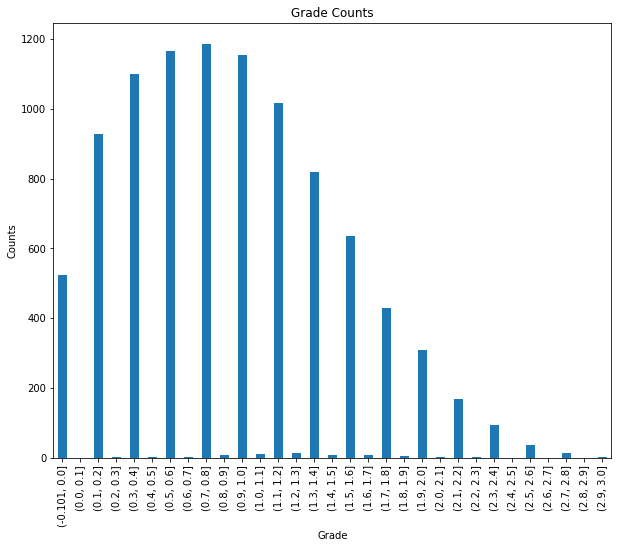

In [53]:
print("Mean grade: {}".format(grades.mean()))
bins = np.arange(-0.1, 3.1, 0.1)
print("bins: {}".format(bins))

grade_counts = grades.value_counts(bins=bins, sort=False)
grade_counts.plot(figsize=(10,8), title="Grade Counts", kind="bar", xlabel="Grade", ylabel="Counts")

### Word/character count/length distribution

In [54]:
# Create new grade bins.
new_bins = np.arange(-0.1, 3.5, 0.5)
print("New Bins: {}".format(new_bins))
train_df['gradeCategory'] = pd.cut(train_df['meanGrade'], bins=new_bins, labels=["<0.5", "<1.0", "<1.5", "<2.0", "<2.5", "<3.0", "3.0"])
train_df.head()

New Bins: [-0.1  0.4  0.9  1.4  1.9  2.4  2.9  3.4]


,id,original,edit,grades,meanGrade,editedSentence,replaceWord,gradeCategory
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2,France is ‘ hunting down its citizens who join...,Isis,<0.5
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6,"Pentagon claims 2,000 % increase in Russian tr...",Syria,<2.0
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0,Iceland PM Calls Snap Vote as Pedophile Furor ...,Coalition,<1.5
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4,"In an apparent first , Iran and Israel slap ea...",engage,<0.5
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0,Trump was told weeks ago that Flynn misled sch...,Vice,<0.5


In [55]:
# Get average word length of edited sentence.
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))


train_df['avgWordLength'] = train_df['editedSentence'].apply(lambda x: avg_word(x))
train_df.head()

,id,original,edit,grades,meanGrade,editedSentence,replaceWord,gradeCategory,avgWordLength
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2,France is ‘ hunting down its citizens who join...,Isis,<0.5,4.266667
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6,"Pentagon claims 2,000 % increase in Russian tr...",Syria,<2.0,4.705882
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0,Iceland PM Calls Snap Vote as Pedophile Furor ...,Coalition,<1.5,5.000000
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4,"In an apparent first , Iran and Israel slap ea...",engage,<0.5,4.500000
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0,Trump was told weeks ago that Flynn misled sch...,Vice,<0.5,4.636364


In [56]:
train_df.groupby(['gradeCategory']).mean()

,id,grades,meanGrade,avgWordLength
gradeCategory,,,,
<0.5,7592.063846,6.261905e+06,0.245280,4.997989
<1.0,7529.421453,1.360546e+11,0.701168,4.956630
<1.5,7535.619032,2.170480e+11,1.177829,4.921622
<2.0,7381.708756,3.071965e+11,1.680584,4.847710
<2.5,7685.178819,1.157486e+12,2.125174,4.861186
<3.0,7586.538462,1.282371e+08,2.648077,4.518674
3.0,2316.500000,3.333300e+04,3.000000,5.156250


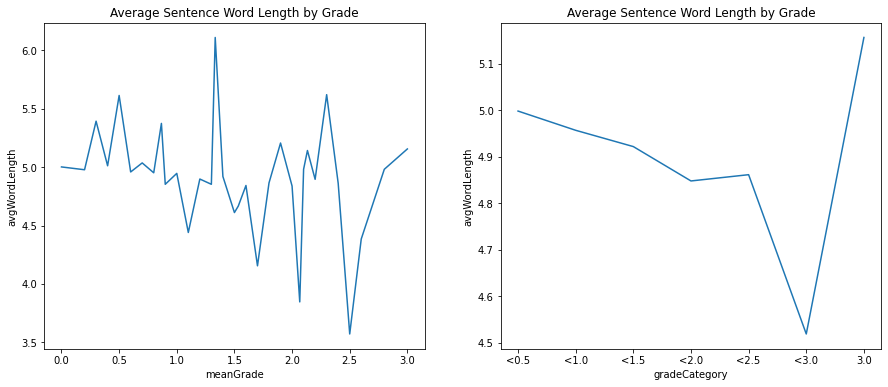

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

train_df.groupby(['meanGrade']).mean()['avgWordLength'].plot(title="Average Sentence Word Length by Grade", ylabel="avgWordLength", ax=axes[0])
train_df.groupby(['gradeCategory']).mean()['avgWordLength'].plot(title="Average Sentence Word Length by Grade", ylabel="avgWordLength", ax=axes[1])

In [58]:
# Word counts per sentence.
train_df['wordCounts'] = train_df['editedSentence'].apply(lambda x: len(str(x).split(" ")))
train_df.head()

,id,original,edit,grades,meanGrade,editedSentence,replaceWord,gradeCategory,avgWordLength,wordCounts
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2,France is ‘ hunting down its citizens who join...,Isis,<0.5,4.266667,15
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6,"Pentagon claims 2,000 % increase in Russian tr...",Syria,<2.0,4.705882,17
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0,Iceland PM Calls Snap Vote as Pedophile Furor ...,Coalition,<1.5,5.000000,11
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4,"In an apparent first , Iran and Israel slap ea...",engage,<0.5,4.500000,12
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0,Trump was told weeks ago that Flynn misled sch...,Vice,<0.5,4.636364,11


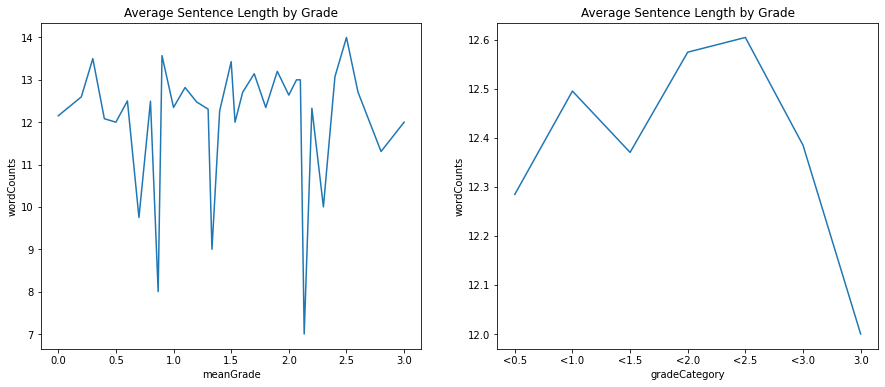

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

train_df.groupby(['meanGrade']).mean()['wordCounts'].plot(title="Average Sentence Length by Grade", ylabel="wordCounts", ax=axes[0])
train_df.groupby(['gradeCategory']).mean()['wordCounts'].plot(title="Average Sentence Length by Grade", ylabel="wordCounts", ax=axes[1])

In [60]:
# Character counts per edited sentence.
train_df['charCounts'] = train_df['editedSentence'].str.len()  # This also includes spaces.
train_df.head()

,id,original,edit,grades,meanGrade,editedSentence,replaceWord,gradeCategory,avgWordLength,wordCounts,charCounts
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2,France is ‘ hunting down its citizens who join...,Isis,<0.5,4.266667,15,78
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6,"Pentagon claims 2,000 % increase in Russian tr...",Syria,<2.0,4.705882,17,96
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0,Iceland PM Calls Snap Vote as Pedophile Furor ...,Coalition,<1.5,5.000000,11,60
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4,"In an apparent first , Iran and Israel slap ea...",engage,<0.5,4.500000,12,65
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0,Trump was told weeks ago that Flynn misled sch...,Vice,<0.5,4.636364,11,61


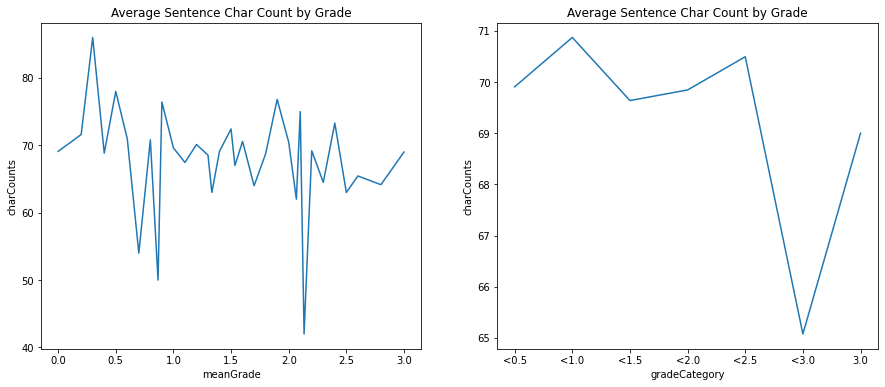

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

train_df.groupby(['meanGrade']).mean()['charCounts'].plot(title="Average Sentence Char Count by Grade", ylabel="charCounts", ax=axes[0])
train_df.groupby(['gradeCategory']).mean()['charCounts'].plot(title="Average Sentence Char Count by Grade", ylabel="charCounts", ax=axes[1])

### Stop word analysis

In [62]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [63]:
# Number of stop words per edited sentence.
train_df['numStopWords'] = train_df['editedSentence'].apply(lambda x: len([x for x in x.split() if x in stop]))
train_df.head()

,id,original,edit,grades,meanGrade,editedSentence,replaceWord,gradeCategory,avgWordLength,wordCounts,charCounts,numStopWords
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2,France is ‘ hunting down its citizens who join...,Isis,<0.5,4.266667,15,78,5
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6,"Pentagon claims 2,000 % increase in Russian tr...",Syria,<2.0,4.705882,17,96,4
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0,Iceland PM Calls Snap Vote as Pedophile Furor ...,Coalition,<1.5,5.000000,11,60,1
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4,"In an apparent first , Iran and Israel slap ea...",engage,<0.5,4.500000,12,65,4
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0,Trump was told weeks ago that Flynn misled sch...,Vice,<0.5,4.636364,11,61,2


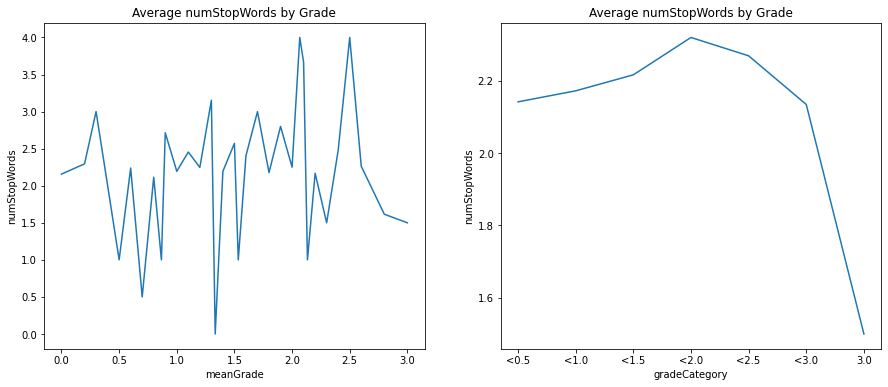

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

train_df.groupby(['meanGrade']).mean()['numStopWords'].plot(title="Average numStopWords by Grade", ylabel="numStopWords", ax=axes[0])
train_df.groupby(['gradeCategory']).mean()['numStopWords'].plot(title="Average numStopWords by Grade", ylabel="numStopWords", ax=axes[1])

### Special characters

In [65]:
# Number of sentences with hashtags.
train_df['editedSentence'].apply(lambda x: len([x for x in x.split() if x.startswith('#')])).value_counts()
train_df['numHashtags'] = train_df['editedSentence'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

In [66]:
# Number of sentences with digits.
train_df['editedSentence'].apply(lambda x: len([x for x in x.split() if x.isdigit()])).value_counts()
train_df['numDigits'] = train_df['editedSentence'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

In [67]:
# Number of upper case words.
train_df['editedSentence'].apply(lambda x: len([x for x in x.split() if x.isupper()])).value_counts()
train_df['numUpperCase'] = train_df['editedSentence'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

In [68]:
train_df.head()

,id,original,edit,grades,meanGrade,editedSentence,replaceWord,gradeCategory,avgWordLength,wordCounts,charCounts,numStopWords,numHashtags,numDigits,numUpperCase
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2,France is ‘ hunting down its citizens who join...,Isis,<0.5,4.266667,15,78,5,0,0,0
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6,"Pentagon claims 2,000 % increase in Russian tr...",Syria,<2.0,4.705882,17,96,4,0,0,0
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0,Iceland PM Calls Snap Vote as Pedophile Furor ...,Coalition,<1.5,5.000000,11,60,1,0,0,1
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4,"In an apparent first , Iran and Israel slap ea...",engage,<0.5,4.500000,12,65,4,0,0,0
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0,Trump was told weeks ago that Flynn misled sch...,Vice,<0.5,4.636364,11,61,2,0,0,0


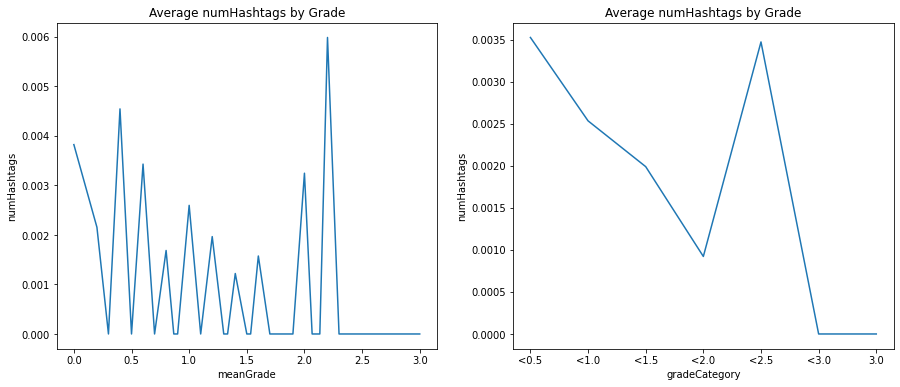

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

train_df.groupby(['meanGrade']).mean()['numHashtags'].plot(title="Average numHashtags by Grade", ylabel="numHashtags", ax=axes[0])
train_df.groupby(['gradeCategory']).mean()['numHashtags'].plot(title="Average numHashtags by Grade", ylabel="numHashtags", ax=axes[1])

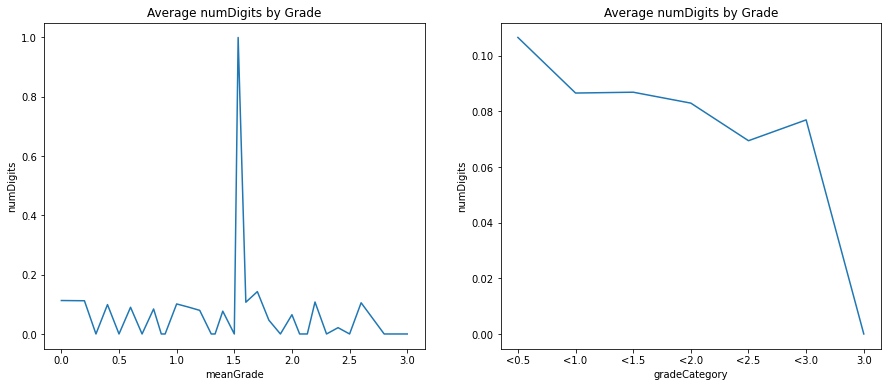

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

train_df.groupby(['meanGrade']).mean()['numDigits'].plot(title="Average numDigits by Grade", ylabel="numDigits", ax=axes[0])
train_df.groupby(['gradeCategory']).mean()['numDigits'].plot(title="Average numDigits by Grade", ylabel="numDigits", ax=axes[1])

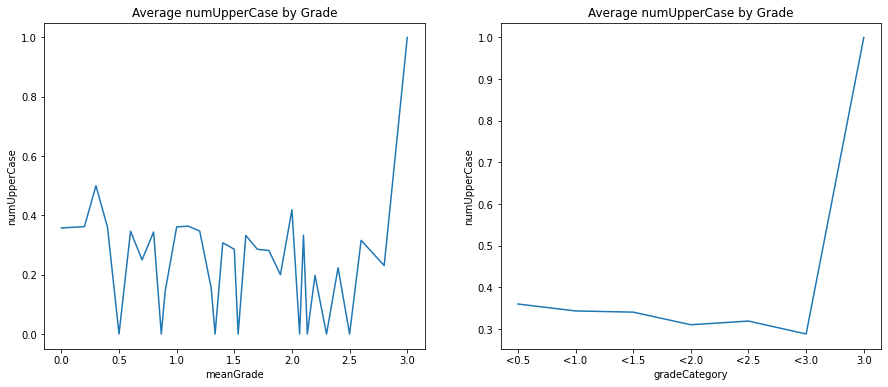

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

train_df.groupby(['meanGrade']).mean()['numUpperCase'].plot(title="Average numUpperCase by Grade", ylabel="numUpperCase", ax=axes[0])
train_df.groupby(['gradeCategory']).mean()['numUpperCase'].plot(title="Average numUpperCase by Grade", ylabel="numUpperCase", ax=axes[1])

## Text preprocessing

### Lower casing

In [72]:
# Create new dataframe.
# Convert all to lowercase.
processed = pd.DataFrame(train_df['editedSentence'].apply(lambda x: " ".join(x.lower() for x in x.split())))
processed['original'] = train_df['original'].apply(lambda x: " ".join(x.lower() for x in x.split()))
processed.head()

,editedSentence,original
0,france is ‘ hunting down its citizens who join...,france is ‘ hunting down its citizens who join...
1,"pentagon claims 2,000 % increase in russian tr...","pentagon claims 2,000 % increase in russian tr..."
2,iceland pm calls snap vote as pedophile furor ...,iceland pm calls snap vote as pedophile furor ...
3,"in an apparent first , iran and israel slap ea...","in an apparent first , iran and israel <engage..."
4,trump was told weeks ago that flynn misled sch...,trump was told weeks ago that flynn misled <vi...


### Remove punctuation

In [73]:
# Remove punctuation.
processed['editedSentence'] = processed['editedSentence'].str.replace('[^\w\s]','')
processed['original'] = processed['original'].str.replace('[^\w\s]','')
processed.head()

,editedSentence,original
0,france is hunting down its citizens who joine...,france is hunting down its citizens who joine...
1,pentagon claims 2000 increase in russian trol...,pentagon claims 2000 increase in russian trol...
2,iceland pm calls snap vote as pedophile furor ...,iceland pm calls snap vote as pedophile furor ...
3,in an apparent first iran and israel slap eac...,in an apparent first iran and israel engage e...
4,trump was told weeks ago that flynn misled sch...,trump was told weeks ago that flynn misled vic...


### Remove stop words

In [74]:
# Remove stop words.
processed['editedSentence'] = processed['editedSentence'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
processed['original'] = processed['original'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
processed.head()

,editedSentence,original
0,france hunting citizens joined twins without t...,france hunting citizens joined isis without tr...
1,pentagon claims 2000 increase russian trolls b...,pentagon claims 2000 increase russian trolls s...
2,iceland pm calls snap vote pedophile furor cra...,iceland pm calls snap vote pedophile furor cra...
3,apparent first iran israel slap militarily,apparent first iran israel engage militarily
4,trump told weeks ago flynn misled school presi...,trump told weeks ago flynn misled vice president


### Word frequencies

In [75]:
# Get set of replacement words.
replacement_words = train_df['edit']
print(replacement_words.value_counts())
print("Num replaced words == 'trump': {}".format(len(train_df[train_df['edit'] == 'trump'])))
print("Mean grade of replaced words == 'party': {}".format(train_df[train_df['edit'] == 'party'].mean()['meanGrade']))
print("Mean grade of replaced words == 'hair': {}".format(train_df[train_df['edit'] == 'hair'].mean()['meanGrade']))
print("Mean grade of replaced words == 'dance': {}".format(train_df[train_df['edit'] == 'dance'].mean()['meanGrade']))
print("Mean grade of replaced words == 'dancing': {}".format(train_df[train_df['edit'] == 'dancing'].mean()['meanGrade']))
print("Mean grade of replaced words == 'circus': {}".format(train_df[train_df['edit'] == 'circus'].mean()['meanGrade']))

party        54
hair         47
dance        42
circus       27
dancing      27
             ..
skiing        1
Diet          1
HANGING       1
geckos        1
appraisal     1
Name: edit, Length: 5372, dtype: int64
Num replaced words == 'trump': 1
Mean grade of replaced words == 'party': 1.007407407407407
Mean grade of replaced words == 'hair': 1.7638297872340423
Mean grade of replaced words == 'dance': 1.2142857142857142
Mean grade of replaced words == 'dancing': 0.9185185185185185
Mean grade of replaced words == 'circus': 1.4407407407407409


In [76]:
# Funniest sentence.
train_df.loc[train_df['meanGrade'].idxmax()]

id                                                             3404
original          President Trump 's first year <anniversary/> r...
edit                                                   Kindergarten
grades                                                        33333
meanGrade                                                         3
editedSentence    President Trump 's first year Kindergarten rep...
replaceWord                                             anniversary
gradeCategory                                                   3.0
avgWordLength                                                4.1875
wordCounts                                                       16
charCounts                                                       82
numStopWords                                                      3
numHashtags                                                       0
numDigits                                                         0
numUpperCase                                    

In [77]:
# Find common words.
freq = pd.Series(' '.join(processed['editedSentence']).split()).value_counts()
top_freq = freq[:10]
top_freq

trump     3345
us         758
says       621
house      502
new        367
nt         367
donald     359
white      348
gop        295
russia     292
dtype: int64

In [78]:
# Find rare words.
bottom_freq = freq[-10:]
bottom_freq

drum             1
rodents          1
miners           1
intoxicates      1
racetrack        1
mailmen          1
sociopaths       1
volume           1
undergarments    1
bandits          1
dtype: int64

In [79]:
# We cannot delete the most/least common words because they are the edited words.
print("Least common words that are replacement words: {}".format(set.intersection(set(bottom_freq.index.tolist()), set(replacement_words.values.tolist()))))
print("Most common words that are replacement words: {}".format(set.intersection(set(top_freq.index.tolist()), set(replacement_words.values.tolist()))))

Least common words that are replacement words: {'rodents', 'bandits', 'racetrack', 'drum', 'undergarments', 'miners', 'intoxicates'}
Most common words that are replacement words: {'house', 'trump'}


### Lemmatization

In [82]:
from textblob import Word, TextBlob
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [83]:
processed['editedSentence'] = processed['editedSentence'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
processed['original'] = processed['original'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
processed.head()

,editedSentence,original
0,france hunting citizen joined twin without tri...,france hunting citizen joined isi without tria...
1,pentagon claim 2000 increase russian troll bow...,pentagon claim 2000 increase russian troll syr...
2,iceland pm call snap vote pedophile furor cras...,iceland pm call snap vote pedophile furor cras...
3,apparent first iran israel slap militarily,apparent first iran israel engage militarily
4,trump told week ago flynn misled school president,trump told week ago flynn misled vice president


## Feature extraction

In [84]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer

### TD-IDF

In [85]:
count_vect = CountVectorizer(stop_words='english')
train_counts_sentence = count_vect.fit_transform(processed['editedSentence'])
transformer = TfidfTransformer().fit(train_counts_sentence)
train_counts_sentence = transformer.transform(train_counts_sentence)
train_counts_sentence

<9652x8977 sparse matrix of type '<class 'numpy.float64'>'
	with 72252 stored elements in Compressed Sparse Row format>

In [89]:
train_counts_edit = count_vect.fit_transform(train_df['edit'])
transformer = TfidfTransformer().fit(train_counts_edit)
train_counts_edit = transformer.transform(train_counts_edit)
train_counts_edit

<9652x4616 sparse matrix of type '<class 'numpy.float64'>'
	with 9537 stored elements in Compressed Sparse Row format>

### BOW

In [86]:
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow_sentence = bow.fit_transform(processed['editedSentence'])
train_bow_sentence

<9652x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 44922 stored elements in Compressed Sparse Row format>

In [90]:
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow_edit = bow.fit_transform(train_df['edit'])
train_bow_edit

<9652x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 5326 stored elements in Compressed Sparse Row format>

### Sentiment

In [91]:
processed['sentiment'] = processed['editedSentence'].apply(lambda x: TextBlob(x).sentiment[0])
processed['sentimentOrig'] = processed['original'].apply(lambda x: TextBlob(x).sentiment[0])
processed

,editedSentence,original,sentiment,sentimentOrig
0,france hunting citizen joined twin without tri...,france hunting citizen joined isi without tria...,0.000000,0.000000
1,pentagon claim 2000 increase russian troll bow...,pentagon claim 2000 increase russian troll syr...,-0.156250,-0.156250
2,iceland pm call snap vote pedophile furor cras...,iceland pm call snap vote pedophile furor cras...,0.000000,0.000000
3,apparent first iran israel slap militarily,apparent first iran israel engage militarily,0.066667,0.066667
4,trump told week ago flynn misled school president,trump told week ago flynn misled vice president,0.000000,0.000000
...,...,...,...,...
9647,state official blast unprecedented dhs idea se...,state official blast unprecedented dhs move se...,0.500000,0.500000
9648,protester rally stewardess detained jfk airpor...,protester rally refugee detained jfk airport t...,0.000000,0.000000
9649,cruise line carnival corp join fight bermuda s...,cruise line carnival corp join fight bermuda s...,0.000000,0.000000
9650,columbia police hunt woman seen cake near univ...,columbia police hunt woman seen gun near unive...,0.100000,0.100000


In [95]:
processed['sentimentDiff'] = processed['sentiment'] - processed['sentimentOrig']
processed.head()

,editedSentence,original,sentiment,sentimentOrig,sentimentDiff
0,france hunting citizen joined twin without tri...,france hunting citizen joined isi without tria...,0.000000,0.000000,0.0
1,pentagon claim 2000 increase russian troll bow...,pentagon claim 2000 increase russian troll syr...,-0.156250,-0.156250,0.0
2,iceland pm call snap vote pedophile furor cras...,iceland pm call snap vote pedophile furor cras...,0.000000,0.000000,0.0
3,apparent first iran israel slap militarily,apparent first iran israel engage militarily,0.066667,0.066667,0.0
4,trump told week ago flynn misled school president,trump told week ago flynn misled vice president,0.000000,0.000000,0.0


In [96]:
# Sentiment diff of replaced vs replacement words.
processed['wordSentimentDiff'] = train_df['edit'].apply(lambda x: TextBlob(x).sentiment[0]) - train_df['replaceWord'].apply(lambda x: TextBlob(x).sentiment[0])
processed.head()

,editedSentence,original,sentiment,sentimentOrig,sentimentDiff,wordSentimentDiff
0,france hunting citizen joined twin without tri...,france hunting citizen joined isi without tria...,0.000000,0.000000,0.0,0.0
1,pentagon claim 2000 increase russian troll bow...,pentagon claim 2000 increase russian troll syr...,-0.156250,-0.156250,0.0,0.0
2,iceland pm call snap vote pedophile furor cras...,iceland pm call snap vote pedophile furor cras...,0.000000,0.000000,0.0,0.0
3,apparent first iran israel slap militarily,apparent first iran israel engage militarily,0.066667,0.066667,0.0,0.0
4,trump told week ago flynn misled school president,trump told week ago flynn misled vice president,0.000000,0.000000,0.0,0.0


In [80]:
# Combine dataframes
data = pd.concat([train_df, processed], axis=1)
data.head()

,id,original,edit,grades,meanGrade,editedSentence,replaceWord,gradeCategory,avgWordLength,wordCounts,charCounts,numStopWords,numHashtags,numDigits,numUpperCase,editedSentence,original
0,14530,France is ‘ hunting down its citizens who join...,twins,10000,0.2,France is ‘ hunting down its citizens who join...,Isis,<0.5,4.266667,15,78,5,0,0,0,france hunting citizens joined twins without t...,france hunting citizens joined isis without tr...
1,13034,"Pentagon claims 2,000 % increase in Russian tr...",bowling,33110,1.6,"Pentagon claims 2,000 % increase in Russian tr...",Syria,<2.0,4.705882,17,96,4,0,0,0,pentagon claims 2000 increase russian trolls b...,pentagon claims 2000 increase russian trolls s...
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor ...,party,22100,1.0,Iceland PM Calls Snap Vote as Pedophile Furor ...,Coalition,<1.5,5.000000,11,60,1,0,0,1,iceland pm calls snap vote pedophile furor cra...,iceland pm calls snap vote pedophile furor cra...
3,76,"In an apparent first , Iran and Israel <engage...",slap,20000,0.4,"In an apparent first , Iran and Israel slap ea...",engage,<0.5,4.500000,12,65,4,0,0,0,apparent first iran israel slap militarily,apparent first iran israel engage militarily
4,6164,Trump was told weeks ago that Flynn misled <Vi...,school,0,0.0,Trump was told weeks ago that Flynn misled sch...,Vice,<0.5,4.636364,11,61,2,0,0,0,trump told weeks ago flynn misled school presi...,trump told weeks ago flynn misled vice president


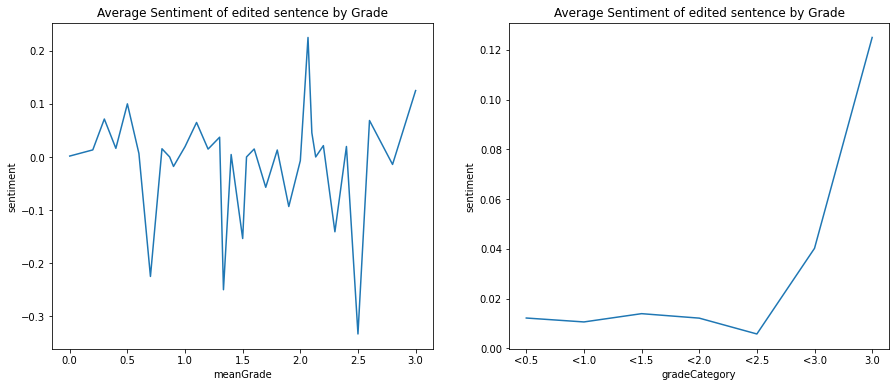

In [100]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

data.groupby(['meanGrade']).mean()['sentiment'].plot(title="Average Sentiment of edited sentence by Grade", ylabel="sentiment", ax=axes[0])
data.groupby(['gradeCategory']).mean()['sentiment'].plot(title="Average Sentiment of edited sentence by Grade", ylabel="sentiment", ax=axes[1])

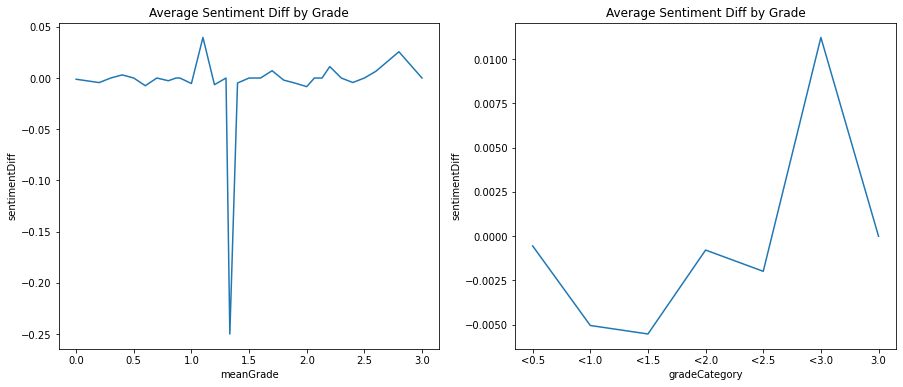

In [101]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

data.groupby(['meanGrade']).mean()['sentimentDiff'].plot(title="Average Sentiment Diff by Grade", ylabel="sentimentDiff", ax=axes[0])
data.groupby(['gradeCategory']).mean()['sentimentDiff'].plot(title="Average Sentiment Diff by Grade", ylabel="sentimentDiff", ax=axes[1])

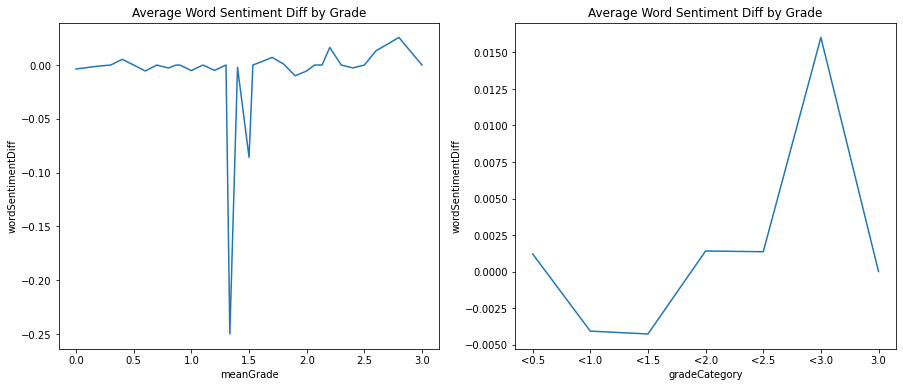

In [102]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

data.groupby(['meanGrade']).mean()['wordSentimentDiff'].plot(title="Average Word Sentiment Diff by Grade", ylabel="wordSentimentDiff", ax=axes[0])
data.groupby(['gradeCategory']).mean()['wordSentimentDiff'].plot(title="Average Word Sentiment Diff by Grade", ylabel="wordSentimentDiff", ax=axes[1])

### Extract numeric features

In [103]:
numeric_data = data.select_dtypes(['number']).drop(columns='id')
numeric_data.head()

,grades,meanGrade,avgWordLength,wordCounts,charCounts,numStopWords,numHashtags,numDigits,numUpperCase,sentiment,sentimentOrig,sentimentDiff,wordSentimentDiff
0,10000,0.2,4.266667,15,78,5,0,0,0,0.000000,0.000000,0.0,0.0
1,33110,1.6,4.705882,17,96,4,0,0,0,-0.156250,-0.156250,0.0,0.0
2,22100,1.0,5.000000,11,60,1,0,0,1,0.000000,0.000000,0.0,0.0
3,20000,0.4,4.500000,12,65,4,0,0,0,0.066667,0.066667,0.0,0.0
4,0,0.0,4.636364,11,61,2,0,0,0,0.000000,0.000000,0.0,0.0


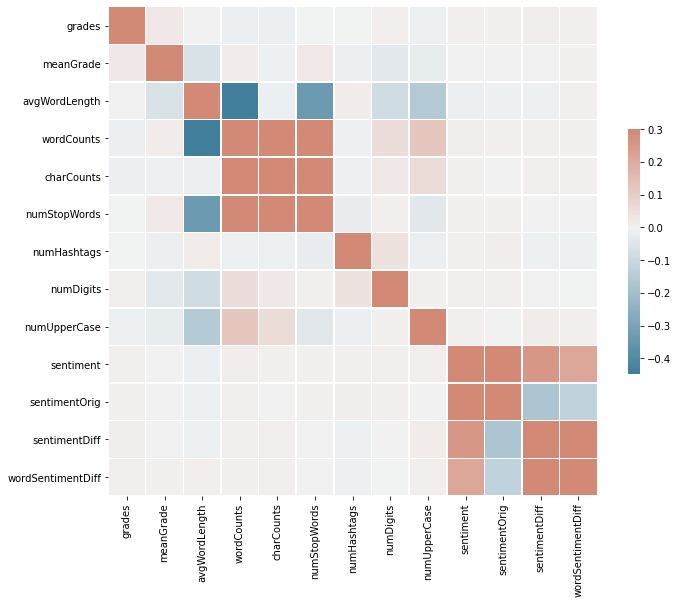

In [104]:
import seaborn as sns

corr = numeric_data.corr()

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Word embeddings

### Own word embedding training

In [226]:
# Train our own word embedding
from gensim.models import Word2Vec
import multiprocessing

import nltk
from nltk.corpus import brown
nltk.download('brown')

news_text = brown.words(categories='news')
sentences = brown.sents()
print(sentences[:4])

EMB_DIM = 100

word2vec = Word2Vec(sentences, size=EMB_DIM, window=5, negative=15, iter=10, workers=multiprocessing.cpu_count())

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.'], ['The', 'September-October', 'term', 'jury', 'had', 'been', 'charged', 'by', 'Fulton', 'Superior', 'Court', 'Judge', 'Durwood', 'Pye', 'to', 'investigate', 'reports', 'of', 'possible', '``', 'irregularities', "''", 'in', 'the', 'hard-fought', 'primary', 'which', 'was', 'won', 'by', 'Mayor

### Pretrained embeddings

In [1]:
import gensim
# Need the interactive Tools for Matplotlib
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
 
from sklearn.manifold import TSNE

In [3]:
# load pre-trained word2vec embeddings
# The embeddings can be downloaded from command prompt:
!wget "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-02-21 16:25:04--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.142.110
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.142.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz.1’

                  G  66%[============>       ]   1.02G  46.6MB/s    eta 13s    ^C


KeyboardInterrupt: ignored

In [2]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [4]:
model.similar_by_word('computer')

[('computers', 0.7979379892349243),
 ('laptop', 0.6640493273735046),
 ('laptop_computer', 0.6548868417739868),
 ('Computer', 0.6473334431648254),
 ('com_puter', 0.6082079410552979),
 ('technician_Leonard_Luchko', 0.5662748217582703),
 ('mainframes_minicomputers', 0.5617721080780029),
 ('laptop_computers', 0.5585449934005737),
 ('PC', 0.5539618134498596),
 ('maker_Dell_DELL.O', 0.5519254207611084)]

### TSNE Plots

In [5]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

In [155]:
import random

def plot_replacement_words(model, words, grades, perplexity):
    vocab = list(model.wv.vocab)
    indices = random.sample(list(range(len(words))), 300)
    words = [words[i] for i in indices]
    grades = [grades[i] for i in indices]

    # Remove words not in vocab.
    for i in range(len(words)-1, -1, -1):
      if words[i] not in vocab:
        words.pop(i)
        grades.pop(i)

    X = model[words]

    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, perplexity=perplexity)
    Y = tsne.fit_transform(X)

    color_dict = { "<0.5":"red", "<1.0":"blue", "<1.5":"green", "<2.0":"purple", "<2.5":"orange", "<3.0":"black", "3.0":"pink" }
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    fig, ax = plt.subplots(figsize=(8,6))
    scatter = ax.scatter(
      x=Y[:, 0], 
      y=Y[:, 1], 
      c=[color_dict[g] for g in grades], 
      label=color_dict.keys, 
      alpha=0.4)
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
    plt.legend(markers, color_dict.keys(), numpoints=1)
    plt.title("Perplexity={}".format(perplexity))
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


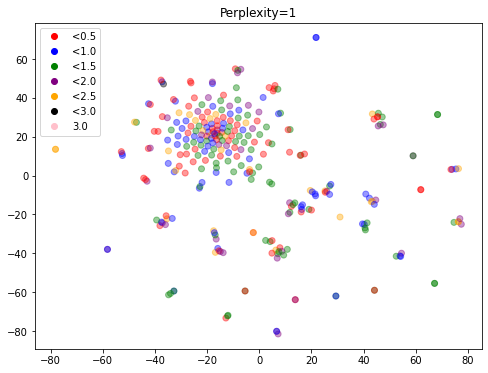

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


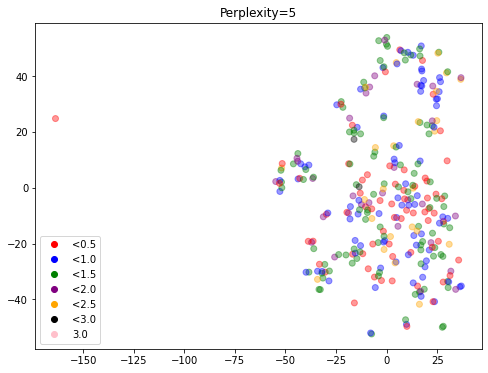

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


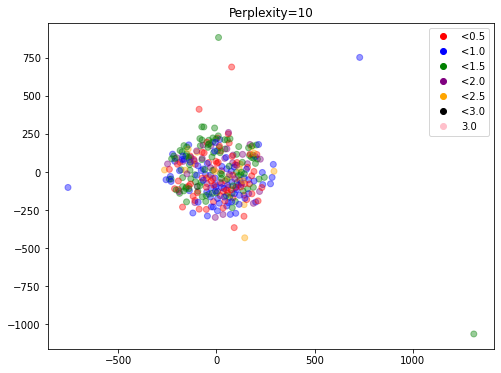

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


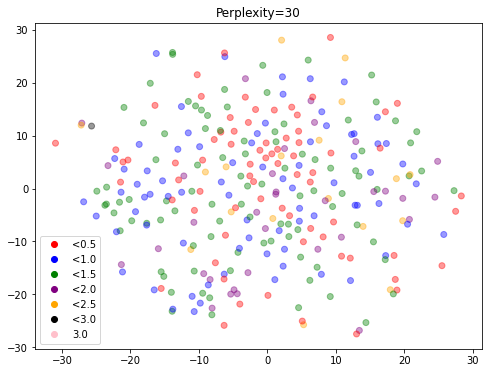

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


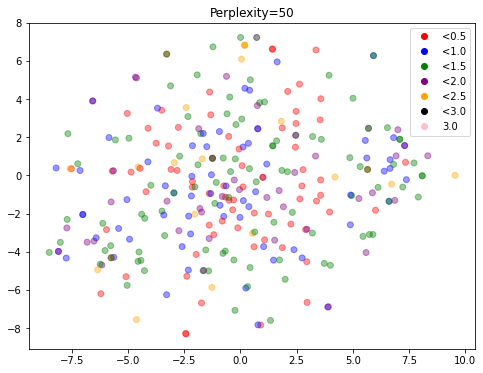

In [156]:
edit_words = data['edit'].values.tolist()
grade_categories = data['gradeCategory'].values.tolist()
for perplexity in [1,5,10,30,50]:
  plot_replacement_words(model, edit_words, grade_categories, perplexity)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


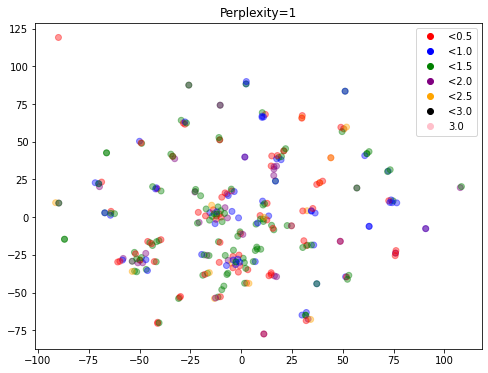

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


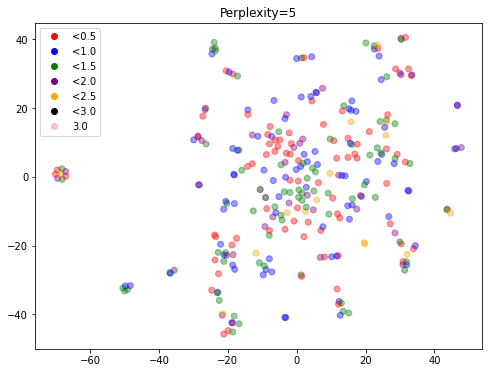

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


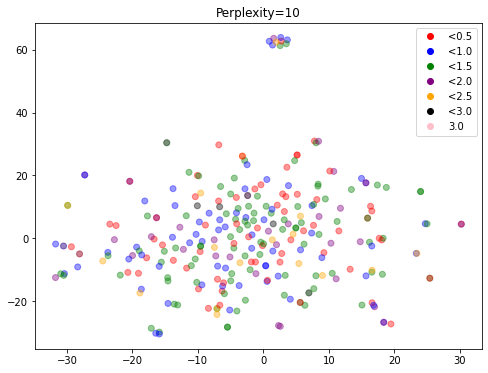

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


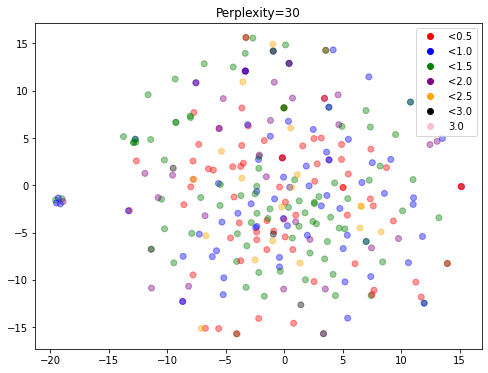

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


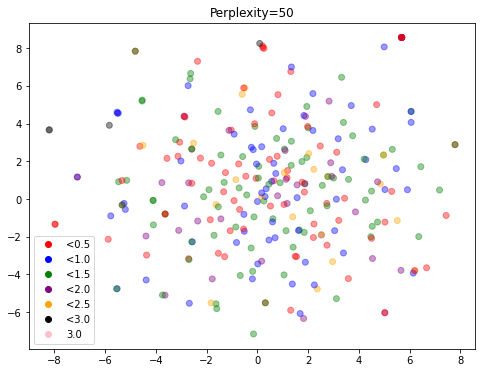

In [157]:
edit_words = data['replaceWord'].values.tolist()
grade_categories = data['gradeCategory'].values.tolist()
for perplexity in [1,5,10,30,50]:
  plot_replacement_words(model, edit_words, grade_categories, perplexity)

In [152]:
# Distance between replaced/replacement word embeddings
def plot_distance(model, editWords, replaceWords, grades, perplexity):
    vocab = list(model.wv.vocab)
    indices = random.sample(list(range(len(editWords))), 300)
    editWords = [editWords[i] for i in indices]
    replaceWords = [replaceWords[i] for i in indices]
    grades = [grades[i] for i in indices]

    # Remove words not in vocab.
    for i in range(len(editWords)-1, -1, -1):
      if (editWords[i] not in vocab) or (replaceWords[i] not in vocab):
        editWords.pop(i)
        replaceWords.pop(i)
        grades.pop(i)

    # Get distance between embeddings.
    editVec = model[editWords]
    replaceVec = model[replaceWords]
    diffVec = editVec - replaceVec

    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, perplexity=perplexity)
    Y = tsne.fit_transform(diffVec)

    color_dict = { "<0.5":"red", "<1.0":"blue", "<1.5":"green", "<2.0":"purple", "<2.5":"orange", "<3.0":"black", "3.0":"pink" }
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    fig, ax = plt.subplots(figsize=(8,6))
    scatter = ax.scatter(
      x=Y[:, 0], 
      y=Y[:, 1], 
      c=[color_dict[g] for g in grades], 
      label=color_dict.keys, 
      alpha=0.4)
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
    plt.legend(markers, color_dict.keys(), numpoints=1)
    plt.title("Perplexity={}".format(perplexity))
    plt.show()

Distance between replaced/replacement word embeddings


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


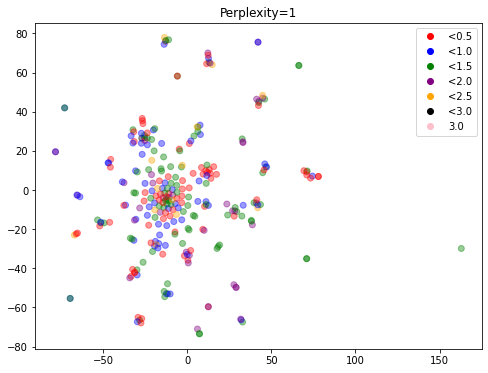

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


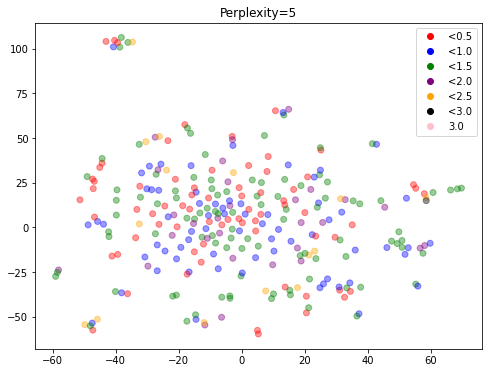

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


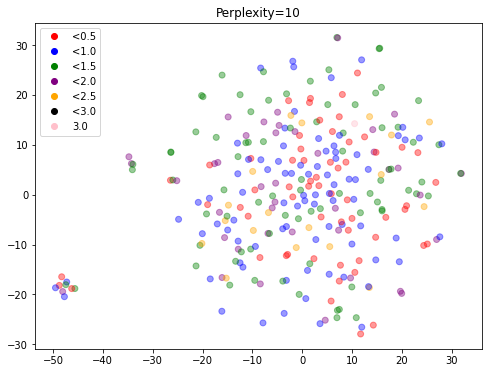

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


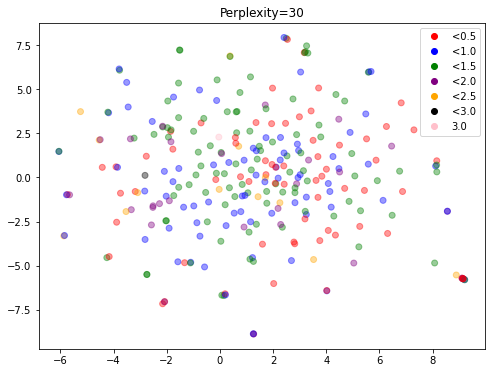

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


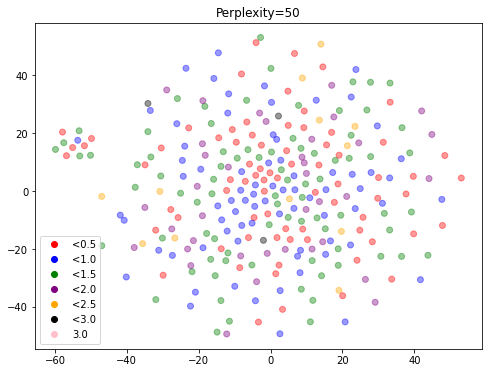

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


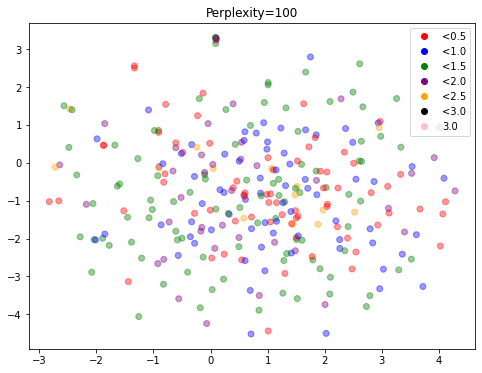

In [154]:
edit_words = data['edit'].values.tolist()
replace_words = data['replaceWord'].values.tolist()
grade_categories = data['gradeCategory'].values.tolist()
print("Distance between replaced/replacement word embeddings")
for perplexity in [1,5,10,30,50,100]:
  plot_distance(model, edit_words, replace_words, grade_categories, perplexity)

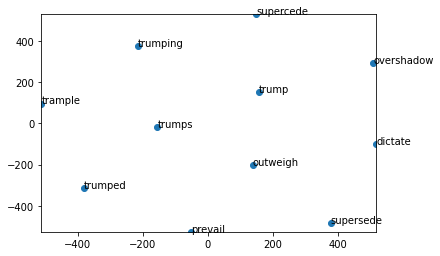

In [143]:
display_closestwords_tsnescatterplot(model, 'trump')

## Train 

In [105]:
from torch.utils.data import Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [195]:
train_proportion = 0.8

### Approach 1 skeleton code

In [231]:
# Setting random seed and device
SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [238]:
# Functions from skeleton code.

# We define our training loop
def train(train_iter, dev_iter, model, number_epoch):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch
    """

    
    print("Training model.")

    for epoch in range(1, number_epoch+1):

        model.train()
        epoch_loss = 0
        epoch_sse = 0
        no_observations = 0  # Observations used for training so far

        for batch in train_iter:

            feature, target = batch

            feature, target = feature.to(device), target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            model.hidden = model.init_hidden()

            predictions = model(feature).squeeze(1)

            optimizer.zero_grad()

            loss = loss_fn(predictions, target)

            sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse

        valid_loss, valid_mse, __, __ = eval(dev_iter, model)

        epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations
        print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
        Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')

# We evaluate performance on our dev set
def eval(data_iter, model):
    """
    Evaluating model performance on the dev set
    """
    model.eval()
    epoch_loss = 0
    epoch_sse = 0
    pred_all = []
    trg_all = []
    no_observations = 0

    with torch.no_grad():
        for batch in data_iter:
            feature, target = batch

            feature, target = feature.to(device), target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            model.hidden = model.init_hidden()

            predictions = model(feature).squeeze(1)
            loss = loss_fn(predictions, target)

            # We get the mse
            pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
            sse, __ = model_performance(pred, trg)

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse
            pred_all.extend(pred)
            trg_all.extend(trg)

    return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

def create_vocab(data):
    """
    Creating a corpus of all the tokens used
    """
    tokenized_corpus = [] # Let us put the tokenized corpus in a list

    for sentence in data:

        tokenized_sentence = []

        for token in sentence.split(' '): # simplest split is

            tokenized_sentence.append(token)

        tokenized_corpus.append(tokenized_sentence)

    # Create single list of all vocabulary
    vocabulary = []  # Let us put all the tokens (mostly words) appearing in the vocabulary in a list

    for sentence in tokenized_corpus:

        for token in sentence:

            if token not in vocabulary:

                if True:
                    vocabulary.append(token)

    return vocabulary, tokenized_corpus

def collate_fn_padd(batch):
    '''
    We add padding to our minibatches and create tensors for our model
    '''

    batch_labels = [l for f, l in batch]
    batch_features = [f for f, l in batch]

    batch_features_len = [len(f) for f, l in batch]

    seq_tensor = torch.zeros((len(batch), max(batch_features_len))).long()

    for idx, (seq, seqlen) in enumerate(zip(batch_features, batch_features_len)):
        seq_tensor[idx, :seqlen] = torch.LongTensor(seq)

    batch_labels = torch.FloatTensor(batch_labels)

    return seq_tensor, batch_labels

class Task1Dataset(Dataset):

    def __init__(self, train_data, labels):
        self.x_train = train_data
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train[item], self.y_train[item]

class BiLSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size, device):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.device = device
        self.batch_size = batch_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2label = nn.Linear(hidden_dim * 2, 1)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly why they have this dimensionality.
        # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
        return torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device), \
               torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device)

    def forward(self, sentence):
        embedded = self.embedding(sentence)
        embedded = embedded.permute(1, 0, 2)

        lstm_out, self.hidden = self.lstm(
            embedded.view(len(embedded), self.batch_size, self.embedding_dim), self.hidden)

        out = self.hidden2label(lstm_out[-1])
        return out

# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.5f} | RMSE: {rmse:.5f} |')

    return sse, mse

In [237]:
## Run approach 1 code using pre-trained embeddings:
word_vectors = word2vec.wv

# We set our training data and test data
training_data = data['editedSentence']
test_data = data['editedSentence']

# Creating word vectors
training_vocab, training_tokenized_corpus = create_vocab(training_data)
test_vocab, test_tokenized_corpus = create_vocab(test_data)

# Creating joint vocab from test and train:
joint_vocab, joint_tokenized_corpus = create_vocab(pd.concat([training_data, test_data]))

print("Vocab created.")

# We create representations for our tokens
wvecs = [] # word vectors
word2idx = [] # word2index
idx2word = []

index = 1
for word in joint_vocab:
  if word in word_vectors.vocab:
    vec = word2vec.wv[word]
    wvecs.append(vec)
    word2idx.append((word, index))
    idx2word.append((index, word))
    index += 1

wvecs = np.array(wvecs)
word2idx = dict(word2idx)
idx2word = dict(idx2word)

vectorized_seqs = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in training_tokenized_corpus]

# To avoid any sentences being empty (if no words match to our word embeddings)
vectorized_seqs = [x if len(x) > 0 else [0] for x in vectorized_seqs]

INPUT_DIM = len(word2idx)
EMBEDDING_DIM = 100
BATCH_SIZE = 32

model = BiLSTM(EMBEDDING_DIM, 50, INPUT_DIM, BATCH_SIZE, device)
print("Model initialised.")

model.to(device)
# We provide the model with our embeddings
model.embedding.weight.data.copy_(torch.from_numpy(wvecs))

feature = vectorized_seqs

# 'feature' is a list of lists, each containing embedding IDs for word tokens
train_and_dev = Task1Dataset(feature, train_df['meanGrade'])

train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples

train_dataset, dev_dataset = random_split(train_and_dev,
                                           (train_examples,
                                            dev_examples))

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

print("Dataloaders created.")

loss_fn = nn.MSELoss()
loss_fn = loss_fn.to(device)

optimizer = torch.optim.Adam(model.parameters())

train(train_loader, dev_loader, model, epochs)

Vocab created.


IndexError: ignored

### Regression model

In [196]:
def train_and_test(x, y):
  training_data, dev_data, training_y, dev_y = train_test_split(x, y, test_size=(1-train_proportion),
                                                                          random_state=42)

  regression_model = DecisionTreeRegressor().fit(training_data, training_y)
  predicted_train = regression_model.predict(training_data)
  predicted_train = np.clip(predicted_train, a_min = 0, a_max = 3) 
  predicted_dev = regression_model.predict(dev_data)
  predicted_dev = np.clip(predicted_dev, a_min = 0, a_max = 3) 

  print("\nTrain performance:")
  sse, mse = model_performance(predicted_train, training_y, True)
  print("\nDev performance:")
  sse, mse = model_performance(predicted_dev, dev_y, True)

In [197]:
# Extract features.
x_df = numeric_data.drop(columns=['meanGrade', 'grades'])
x = x_df.values
print(x[0])
y = numeric_data['meanGrade'].values
print("x shape: {}, y shape: {}".format(x.shape, y.shape))

[ 4.26666667 15.         78.          5.          0.          0.
  0.          0.          0.          0.          0.        ]
x shape: (9652, 11), y shape: (9652,)


In [198]:
print("Features: {}".format(x_df.columns))
train_and_test(x, y)

Features: Index(['avgWordLength', 'wordCounts', 'charCounts', 'numStopWords',
       'numHashtags', 'numDigits', 'numUpperCase', 'sentiment',
       'sentimentOrig', 'sentimentDiff', 'wordSentimentDiff'],
      dtype='object')

Train performance:
| MSE: 0.06295 | RMSE: 0.25090 |

Dev performance:
| MSE: 0.63417 | RMSE: 0.79635 |


In [199]:
for column in x_df.columns:
  new_data = x_df.drop(columns=column)
  new_x = new_data.values
  print("Features: {}".format(new_data.columns))
  train_and_test(new_x, y)

Features: Index(['wordCounts', 'charCounts', 'numStopWords', 'numHashtags', 'numDigits',
       'numUpperCase', 'sentiment', 'sentimentOrig', 'sentimentDiff',
       'wordSentimentDiff'],
      dtype='object')

Train performance:
| MSE: 0.08165 | RMSE: 0.28574 |

Dev performance:
| MSE: 0.59771 | RMSE: 0.77312 |
Features: Index(['avgWordLength', 'charCounts', 'numStopWords', 'numHashtags',
       'numDigits', 'numUpperCase', 'sentiment', 'sentimentOrig',
       'sentimentDiff', 'wordSentimentDiff'],
      dtype='object')

Train performance:
| MSE: 0.06295 | RMSE: 0.25090 |

Dev performance:
| MSE: 0.62948 | RMSE: 0.79340 |
Features: Index(['avgWordLength', 'wordCounts', 'numStopWords', 'numHashtags',
       'numDigits', 'numUpperCase', 'sentiment', 'sentimentOrig',
       'sentimentDiff', 'wordSentimentDiff'],
      dtype='object')

Train performance:
| MSE: 0.06436 | RMSE: 0.25369 |

Dev performance:
| MSE: 0.61637 | RMSE: 0.78509 |
Features: Index(['avgWordLength', 'wordCounts', 'cha

In [200]:
new_data = np.expand_dims(x_df['sentimentDiff'], axis=1)
train_and_test(new_data, y)


Train performance:
| MSE: 0.33197 | RMSE: 0.57617 |

Dev performance:
| MSE: 0.34809 | RMSE: 0.58999 |


In [201]:
train_and_test(train_counts_edit, y)


Train performance:
| MSE: 0.13444 | RMSE: 0.36666 |

Dev performance:
| MSE: 0.36481 | RMSE: 0.60400 |


### MLP

In [218]:
# Define simple model architecture.
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()                    
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)                
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):                              
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([7721])) that is different to the input size (torch.Size([7721, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1931])) that is different to the input size (torch.Size([1931, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 | Train loss: 0.05346910282969475 | Test loss: 31274768.0
Epoch: 2 | Train loss: 7823476.0 | Test loss: 3740783.75
Epoch: 3 | Train loss: 935559.375 | Test loss: 1346682.0
Epoch: 4 | Train loss: 336801.28125 | Test loss: 484805.6875
Epoch: 5 | Train loss: 121248.4296875 | Test loss: 174530.109375
Epoch: 6 | Train loss: 43649.43359375 | Test loss: 62830.875
Epoch: 7 | Train loss: 15713.798828125 | Test loss: 22619.130859375
Epoch: 8 | Train loss: 5656.96533203125 | Test loss: 8142.89990234375
Epoch: 9 | Train loss: 2036.507568359375 | Test loss: 2931.4521484375
Epoch: 10 | Train loss: 733.1426391601562 | Test loss: 1055.3275146484375
Epoch: 11 | Train loss: 263.931396484375 | Test loss: 379.9208984375
Epoch: 12 | Train loss: 95.01531982421875 | Test loss: 136.77337646484375
Epoch: 13 | Train loss: 34.20555114746094 | Test loss: 49.23957443237305
Epoch: 14 | Train loss: 12.3140287399292 | Test loss: 17.72698211669922
Epoch: 15 | Train loss: 4.433076858520508 | Test loss: 6.38220

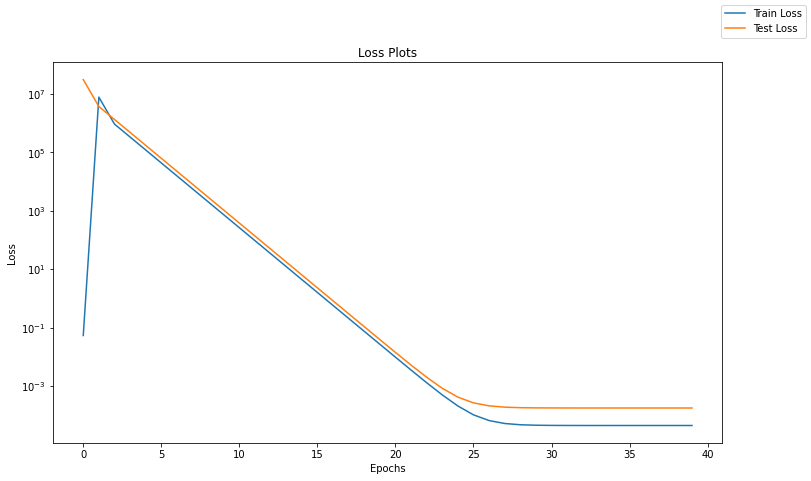

In [240]:
net = Net(input_size=11, hidden_size=20, output_size=1)
net.cuda()
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()

num_epochs = 40

training_data, test_data, training_y, test_y = train_test_split(x, y, test_size=(1-train_proportion),
                                                                          random_state=42)
x_train = torch.Tensor(training_data).cuda()
y_train = torch.Tensor(training_y).cuda()
x_test = torch.Tensor(test_data).cuda()
y_test = torch.Tensor(test_y).cuda()

train_loss = []
test_loss = []

# Train the network
for t in range(num_epochs):
    tr_loss = 0
    te_loss = 0
    prediction = net(x_train)     

    tr_loss = loss_func(prediction, y_train)
    train_loss.append(tr_loss/len(x_train))

    optimizer.zero_grad()   
    tr_loss.backward()        
    optimizer.step()       
    
    with torch.no_grad():
      test_pred = net(x_test)
      te_loss = loss_func(test_pred, y_test)
      test_loss.append(te_loss/len(x_test))
   
    print("Epoch: {} | Train loss: {} | Test loss: {}".format(t+1, tr_loss/len(x_train), te_loss/len(x_test)))


fig, ax = plt.subplots(figsize=(12,7))
ax.set_title('Loss Plots')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.plot(list(range(t+1)), train_loss, label="Train Loss")
ax.plot(list(range(t+1)), test_loss, label="Test Loss")
fig.legend()

In [220]:
# Test
predicted_train = net(x_train).cpu().detach().numpy()
predicted_test = net(x_test).cpu().detach().numpy()
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)
print("\nDev performance:")
sse, mse = model_performance(predicted_test, test_y, True)


Train performance:
| MSE: 0.34100 | RMSE: 0.58395 |

Dev performance:
| MSE: 0.33904 | RMSE: 0.58227 |


(9652, 8988)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([7721])) that is different to the input size (torch.Size([7721, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1931])) that is different to the input size (torch.Size([1931, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 | Train loss: 0.00016113098536152393 | Test loss: 73.0867691040039
Epoch: 2 | Train loss: 18.10210418701172 | Test loss: 10.180313110351562
Epoch: 3 | Train loss: 2.5457711219787598 | Test loss: 3.6653075218200684
Epoch: 4 | Train loss: 0.9165061116218567 | Test loss: 1.3197932243347168
Epoch: 5 | Train loss: 0.3299703896045685 | Test loss: 0.47534021735191345
Epoch: 6 | Train loss: 0.11881761252880096 | Test loss: 0.1712961494922638
Epoch: 7 | Train loss: 0.0428025983273983 | Test loss: 0.06181575357913971
Epoch: 8 | Train loss: 0.015437203459441662 | Test loss: 0.02238810807466507
Epoch: 9 | Train loss: 0.005585657898336649 | Test loss: 0.008185327053070068
Epoch: 10 | Train loss: 0.0020391028374433517 | Test loss: 0.003067030105739832
Epoch: 11 | Train loss: 0.0007623425917699933 | Test loss: 0.001221265527419746
Epoch: 12 | Train loss: 0.00030270899878814816 | Test loss: 0.0005548839690163732
Epoch: 13 | Train loss: 0.000137240975163877 | Test loss: 0.0003138424945063889
E

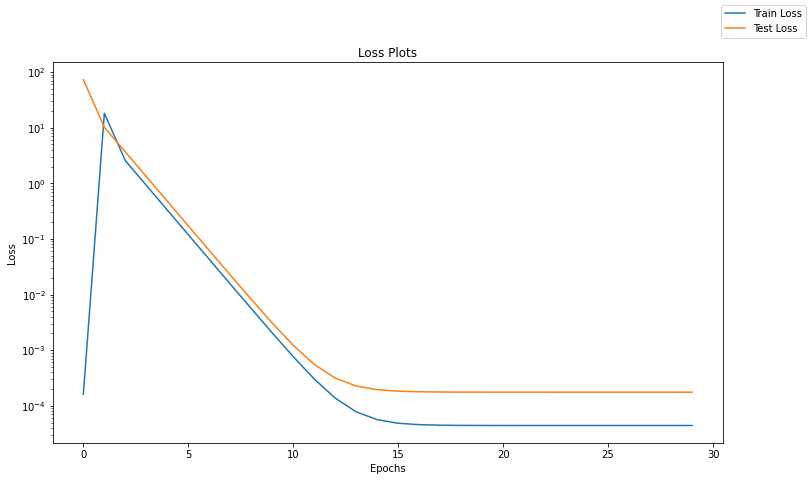

In [221]:
net = Net(input_size=8988, hidden_size=20, output_size=1)
net.cuda()
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()

num_epochs = 30

x_tfidf = np.concatenate((train_counts_sentence.toarray(), x), axis=1)
print(x_tfidf.shape)
training_data, test_data, training_y, test_y = train_test_split(x_tfidf, y, test_size=(1-train_proportion),
                                                                          random_state=42)
x_train = torch.Tensor(training_data).cuda()
y_train = torch.Tensor(training_y).cuda()
x_test = torch.Tensor(test_data).cuda()
y_test = torch.Tensor(test_y).cuda()

train_loss = []
test_loss = []

# Train the network
for t in range(num_epochs):
    tr_loss = 0
    te_loss = 0
    prediction = net(x_train)     

    tr_loss = loss_func(prediction, y_train)
    train_loss.append(tr_loss/len(x_train))

    optimizer.zero_grad()   
    tr_loss.backward()        
    optimizer.step()       
    
    with torch.no_grad():
      test_pred = net(x_test)
      te_loss = loss_func(test_pred, y_test)
      test_loss.append(te_loss/len(x_test))
   
    print("Epoch: {} | Train loss: {} | Test loss: {}".format(t+1, tr_loss/len(x_train), te_loss/len(x_test)))


fig, ax = plt.subplots(figsize=(12,7))
ax.set_title('Loss Plots')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.plot(list(range(t+1)), train_loss, label="Train Loss")
ax.plot(list(range(t+1)), test_loss, label="Test Loss")
fig.legend()

In [222]:
# Test
predicted_train = net(x_train).cpu().detach().numpy()
print(predicted_train)
predicted_test = net(x_test).cpu().detach().numpy()
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)
print("\nDev performance:")
sse, mse = model_performance(predicted_test, test_y, True)

[[0.933856]
 [0.933856]
 [0.933856]
 ...
 [0.933856]
 [0.933856]
 [0.933856]]

Train performance:
| MSE: 0.34100 | RMSE: 0.58395 |

Dev performance:
| MSE: 0.33904 | RMSE: 0.58227 |


(9652, 1011)
Epoch: 1 | Train loss: 0.00036487088073045015 | Test loss: 1049.9114990234375
Epoch: 2 | Train loss: 258.6354064941406 | Test loss: 146.60060119628906
Epoch: 3 | Train loss: 36.663265228271484 | Test loss: 52.77739715576172
Epoch: 4 | Train loss: 13.198802947998047 | Test loss: 19.000619888305664
Epoch: 5 | Train loss: 4.7515974044799805 | Test loss: 6.840723037719727
Epoch: 6 | Train loss: 1.7106029987335205 | Test loss: 2.4630050659179688
Epoch: 7 | Train loss: 0.615845263004303 | Test loss: 0.8869335651397705
Epoch: 8 | Train loss: 0.22173254191875458 | Test loss: 0.3194922208786011
Epoch: 9 | Train loss: 0.07985197752714157 | Test loss: 0.11517981439828873
Epoch: 10 | Train loss: 0.028774986043572426 | Test loss: 0.04160724952816963
Epoch: 11 | Train loss: 0.010387256741523743 | Test loss: 0.015109066851437092
Epoch: 12 | Train loss: 0.0037676775828003883 | Test loss: 0.005562486592680216
Epoch: 13 | Train loss: 0.0013846303336322308 | Test loss: 0.002121375408023596
E

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([7721])) that is different to the input size (torch.Size([7721, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1931])) that is different to the input size (torch.Size([1931, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 19 | Train loss: 4.708308188128285e-05 | Test loss: 0.00018053520761895925
Epoch: 20 | Train loss: 4.521562732406892e-05 | Test loss: 0.00017754329019226134
Epoch: 21 | Train loss: 4.454333975445479e-05 | Test loss: 0.00017639328143559396
Epoch: 22 | Train loss: 4.430133049027063e-05 | Test loss: 0.00017593552183825523
Epoch: 23 | Train loss: 4.421420089784078e-05 | Test loss: 0.00017574448429513723
Epoch: 24 | Train loss: 4.4182826968608424e-05 | Test loss: 0.00017565993766766042
Epoch: 25 | Train loss: 4.41715274064336e-05 | Test loss: 0.00017562007997184992
Epoch: 26 | Train loss: 4.4167452870169654e-05 | Test loss: 0.00017560004198458046
Epoch: 27 | Train loss: 4.416600495460443e-05 | Test loss: 0.0001755894481902942
Epoch: 28 | Train loss: 4.4165488361613825e-05 | Test loss: 0.00017558356921654195
Epoch: 29 | Train loss: 4.416529191075824e-05 | Test loss: 0.00017558025137986988
Epoch: 30 | Train loss: 4.416523006511852e-05 | Test loss: 0.0001755783159751445


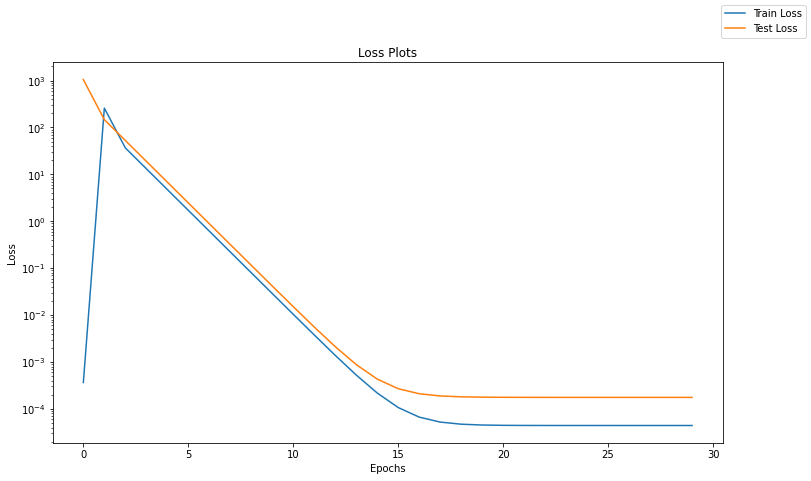

In [225]:
net = Net(input_size=1011, hidden_size=20, output_size=1)
net.cuda()
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()

num_epochs = 30

x_tfidf = np.concatenate((train_bow_sentence.toarray(), x), axis=1)
print(x_tfidf.shape)
training_data, test_data, training_y, test_y = train_test_split(x_tfidf, y, test_size=(1-train_proportion),
                                                                          random_state=42)
x_train = torch.Tensor(training_data).cuda()
y_train = torch.Tensor(training_y).cuda()
x_test = torch.Tensor(test_data).cuda()
y_test = torch.Tensor(test_y).cuda()

train_loss = []
test_loss = []

# Train the network
for t in range(num_epochs):
    tr_loss = 0
    te_loss = 0
    prediction = net(x_train)     

    tr_loss = loss_func(prediction, y_train)
    train_loss.append(tr_loss/len(x_train))

    optimizer.zero_grad()   
    tr_loss.backward()        
    optimizer.step()       
    
    with torch.no_grad():
      test_pred = net(x_test)
      te_loss = loss_func(test_pred, y_test)
      test_loss.append(te_loss/len(x_test))
   
    print("Epoch: {} | Train loss: {} | Test loss: {}".format(t+1, tr_loss/len(x_train), te_loss/len(x_test)))


fig, ax = plt.subplots(figsize=(12,7))
ax.set_title('Loss Plots')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.plot(list(range(t+1)), train_loss, label="Train Loss")
ax.plot(list(range(t+1)), test_loss, label="Test Loss")
fig.legend()

TODO:
- concat train_counts and train_bow
- concat tfidf on replaced/replacement words
- concat tfidf with x
- train word embeddings
- tsne on embedding pairs, colour coded